In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
data = tf.keras.utils.image_dataset_from_directory(directory = 'dataset',
                                                   color_mode = 'rgb',
                                                   batch_size = 64,
                                                   image_size = (224,224),
                                                   shuffle=True,
                                                   seed = 2022)

Found 4217 files belonging to 4 classes.


In [4]:
labels = np.concatenate([y for x,y in data], axis=0)


In [5]:
values = pd.value_counts(labels)
values = values.sort_index()

In [6]:
class_names = data.class_names
for idx, name in enumerate(class_names):
  print(f"{idx} = {name}", end=", ")

0 = cataract, 1 = diabetic_retinopathy, 2 = glaucoma, 3 = normal, 

In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

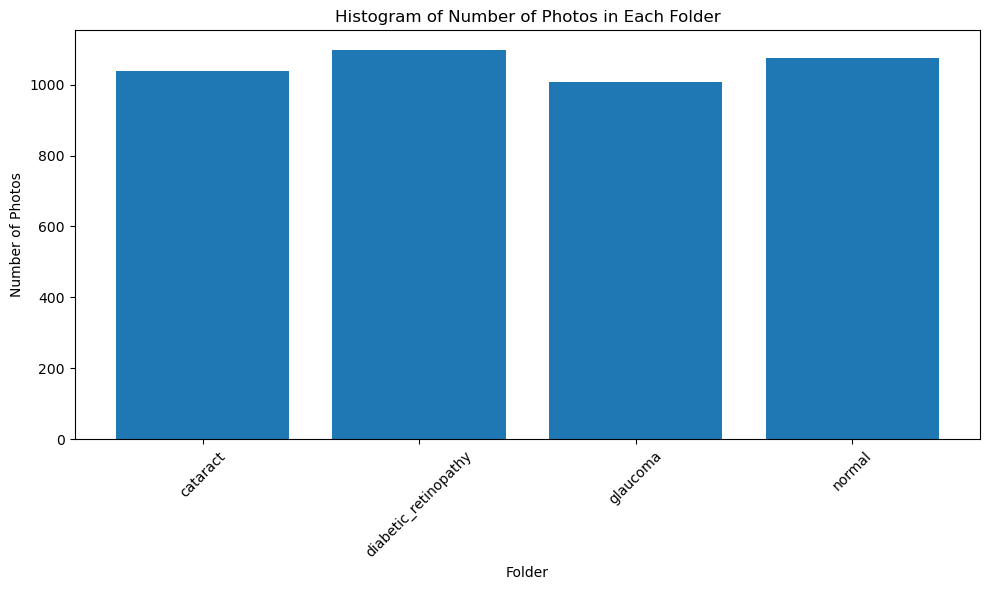

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, values)
plt.xlabel('Folder')
plt.ylabel('Number of Photos')
plt.title('Histogram of Number of Photos in Each Folder')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

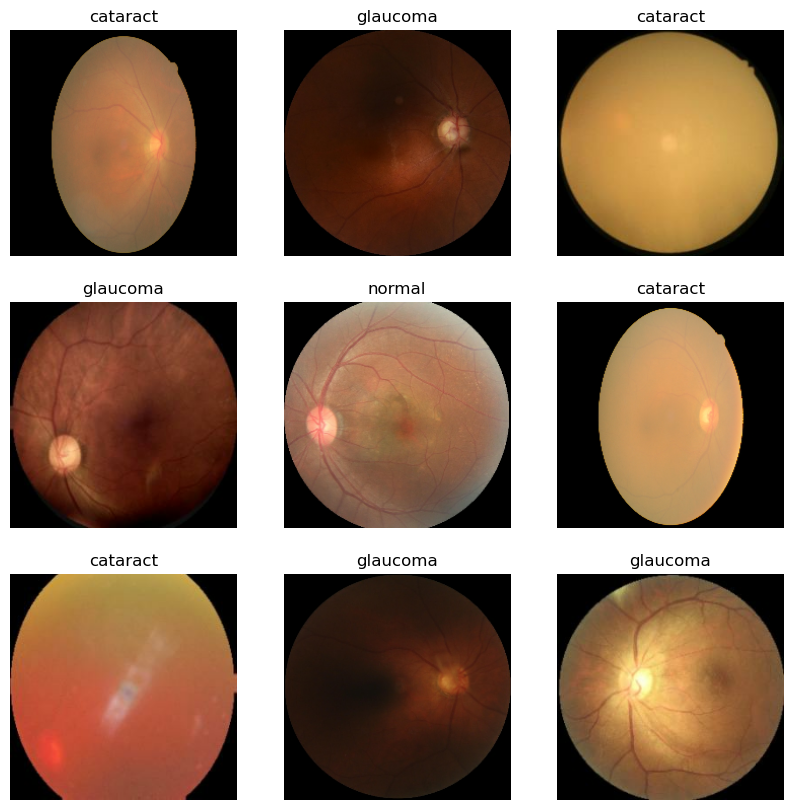

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
data = data.map(lambda x, y: (x/255, y))

In [12]:
sample = data.as_numpy_iterator().next()

In [13]:
print("Total number of batchs = ",len(data))

Total number of batchs =  66


In [14]:
train_size = int(0.7 * len(data)) +1
val_size = int(0.2 * len(data))
test_size = int(0.1 * len(data))

In [15]:
train = data.take(train_size)
remaining = data.skip(train_size)
val = remaining.take(val_size)
test = remaining.skip(val_size)

In [16]:
test_iter = test.as_numpy_iterator()

In [17]:
test_set = {"images":np.empty((0,224,224,3)), "labels":np.empty(0)}
while True:
  try:
    batch = test_iter.next()
    test_set['images'] = np.concatenate((test_set['images'], batch[0]))
    test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
  except:
    break

In [18]:
y_true = test_set['labels']

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [20]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_his(history):
    plt.figure(figsize=(15,12))
    metrics = ['accuracy', 'loss']
    for i, metric in enumerate(metrics):
        plt.subplot(220+1+i)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
    plt.show()

In [21]:
def create_baselineCNN():
    model = Sequential([
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same', input_shape=(224,224,3)),
        Conv2D(filters = 64, kernel_size=3, activation = 'relu',padding='same'),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),

        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        Conv2D(filters = 128, kernel_size=3,padding='same', activation = 'relu',),
        BatchNormalization(),
        MaxPool2D(2),
        Dropout(0.3),
        
        Flatten(),
        Dense(64, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(128, activation = 'relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(4, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    return model

In [22]:
model_CNN = create_baselineCNN()

In [23]:
model_CNN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     7

In [24]:
history = model_CNN.fit(
    train,
    validation_data=val,
    epochs = 40,
)

Epoch 1/40


2023-08-13 20:28:45.952296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 84s 1s/step - loss: 1.3896 - accuracy: 0.4252 - val_loss: 5.1433 - val_accuracy: 0.2476
Epoch 2/40
47/47 [==============================] - 45s 908ms/step - loss: 1.1020 - accuracy: 0.5123 - val_loss: 4.2291 - val_accuracy: 0.2524
Epoch 3/40
47/47 [==============================] - 45s 903ms/step - loss: 0.9926 - accuracy: 0.5545 - val_loss: 5.2046 - val_accuracy: 0.2416
Epoch 4/40
47/47 [==============================] - 45s 899ms/step - loss: 0.8802 - accuracy: 0.5971 - val_loss: 4.6144 - val_accuracy: 0.2584
Epoch 5/40
47/47 [==============================] - 46s 918ms/step - loss: 0.8124 - accuracy: 0.6193 - val_loss: 6.2974 - val_accuracy: 0.2464
Epoch 6/40
47/47 [==============================] - 65s 1s/step - loss: 0.7645 - accuracy: 0.6433 - val_loss: 5.5571 - val_accuracy: 0.2536
Epoch 7/40
47/47 [==============================] - 65s 1s/step - loss: 0.7464 - accuracy: 0.6626 - val_loss: 5.2431 - val_accuracy: 0.2536
Epoch 8/40
47/47 [=

In [26]:
y_pred_CNN = np.argmax(model_CNN.predict(test_set['images']), 1)

12/12 [==============================] - 3s 116ms/step


In [27]:
print(classification_report(y_true, y_pred_CNN, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.87      0.39      0.53       101
diabetic_retinopathy       0.61      1.00      0.75        89
            glaucoma       0.51      0.30      0.38        82
              normal       0.57      0.73      0.64       105

            accuracy                           0.61       377
           macro avg       0.64      0.61      0.58       377
        weighted avg       0.64      0.61      0.58       377



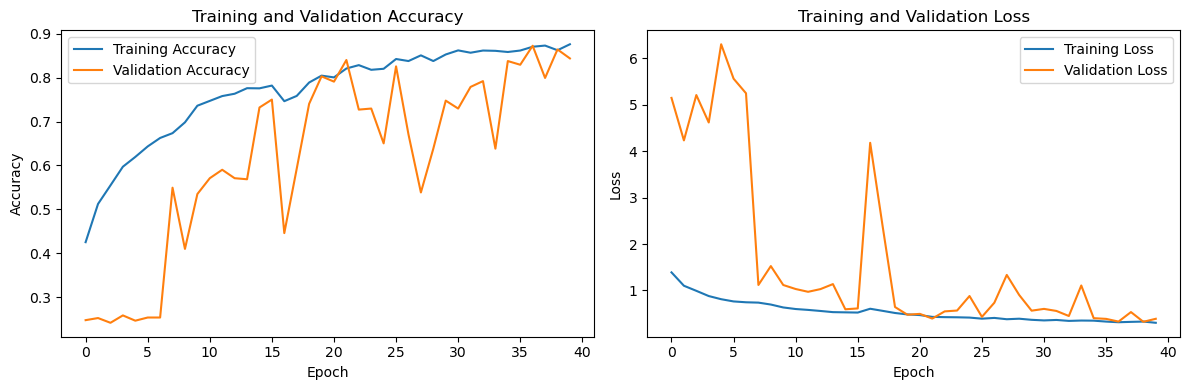

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

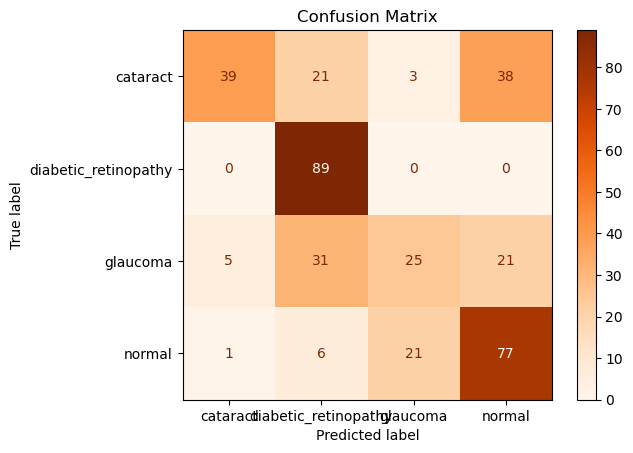

In [29]:
conf_matrix = confusion_matrix(y_true, y_pred_CNN)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Oranges)
plt.title('Confusion Matrix')
plt.show()

In [31]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model

def resnet_block(inputs, filters, kernel_size, strides=(1, 1), activation='relu', conv_shortcut=False):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    if conv_shortcut:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
        x = Add()([x, shortcut])
    else:
        x = Add()([x, inputs])
    
    x = Activation(activation)(x)
    return x

def create_resnet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = resnet_block(x, 64, (3, 3), conv_shortcut=True)
    x = resnet_block(x, 64, (3, 3))
    
    x = resnet_block(x, 128, (3, 3), strides=(2, 2), conv_shortcut=True)
    x = resnet_block(x, 128, (3, 3))
    
    x = resnet_block(x, 256, (3, 3), strides=(2, 2), conv_shortcut=True)
    x = resnet_block(x, 256, (3, 3))
    
    x = resnet_block(x, 512, (3, 3), strides=(2, 2), conv_shortcut=True)
    x = resnet_block(x, 512, (3, 3))
    
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

input_shape = (224, 224, 3)
num_classes = 4
resnet_model = create_resnet18(input_shape, num_classes)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(resnet_model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 112, 112, 64  256        ['conv2d_7[0][0]']               
 rmalization)                   )                                                             

In [32]:
history = resnet_model.fit(
    train,
    validation_data=val,
    epochs = 40,
)

Epoch 1/40
47/47 [==============================] - 56s 793ms/step - loss: 1.4980 - accuracy: 0.4478 - val_loss: 15.9344 - val_accuracy: 0.2464
Epoch 2/40
47/47 [==============================] - 41s 820ms/step - loss: 0.8578 - accuracy: 0.6190 - val_loss: 2.0700 - val_accuracy: 0.2572
Epoch 3/40
47/47 [==============================] - 40s 816ms/step - loss: 0.7352 - accuracy: 0.6582 - val_loss: 3.1853 - val_accuracy: 0.2464
Epoch 4/40
47/47 [==============================] - 41s 831ms/step - loss: 0.6448 - accuracy: 0.7191 - val_loss: 3.8697 - val_accuracy: 0.2296
Epoch 5/40
47/47 [==============================] - 41s 817ms/step - loss: 0.6162 - accuracy: 0.7277 - val_loss: 3.0318 - val_accuracy: 0.2031
Epoch 6/40
47/47 [==============================] - 41s 817ms/step - loss: 0.5945 - accuracy: 0.7473 - val_loss: 4.6550 - val_accuracy: 0.2524
Epoch 7/40
47/47 [==============================] - 41s 814ms/step - loss: 0.5466 - accuracy: 0.7620 - val_loss: 3.2570 - val_accuracy: 0.317

In [33]:
y_pred_resnet = np.argmax(resnet_model.predict(test_set['images']), 1)

12/12 [==============================] - 1s 51ms/step


In [34]:
print(classification_report(y_true, y_pred_resnet, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.93      0.68      0.79       101
diabetic_retinopathy       0.99      0.99      0.99        89
            glaucoma       0.74      0.82      0.77        82
              normal       0.77      0.90      0.83       105

            accuracy                           0.85       377
           macro avg       0.86      0.85      0.85       377
        weighted avg       0.86      0.85      0.85       377



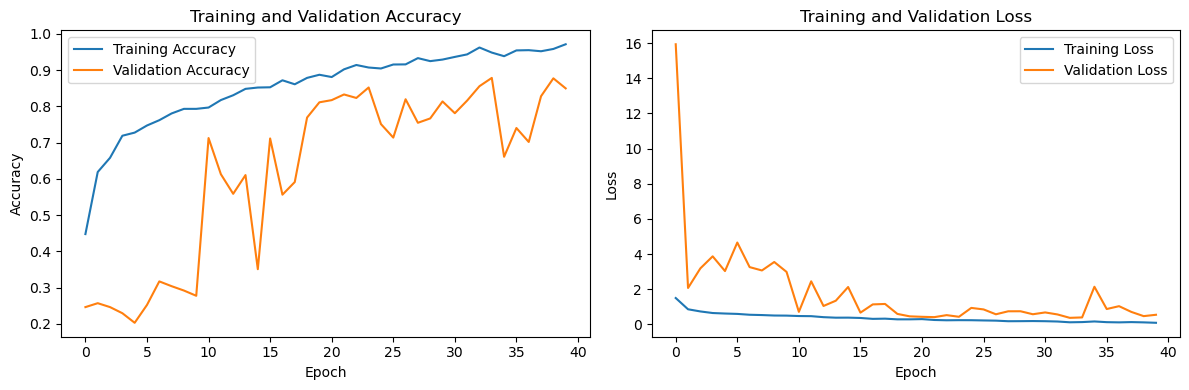

In [35]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

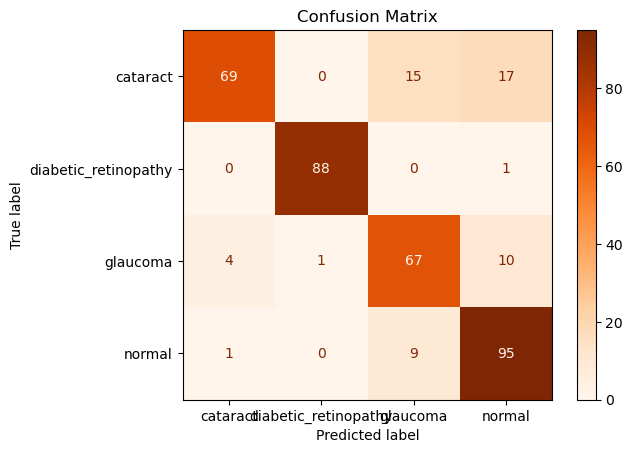

In [36]:
conf_matrix = confusion_matrix(y_true, y_pred_resnet)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Oranges)
plt.title('Confusion Matrix')
plt.show()

In [37]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras import regularizers

def make_model():
    effnet = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')
    effnet.trainable = False
    
    for layer in effnet.layers[83:]:
        layer.trainable = True
    
    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer=regularizers.l2(l=0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006),
              activation='relu')(x)
    x = Dropout(rate=0.45, seed=2022)(x)
    output = Dense(4, activation='softmax')(x)
    
    model_Efficientnet = tf.keras.Model(inputs=effnet.input, outputs=output)
    model_Efficientnet.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model_Efficientnet

# Create the model
model_Efficientnet = make_model()


43941136/43941136 [==============================] - 0s 0us/step


In [38]:
history = model_Efficientnet.fit(
    train,
    validation_data=val,
    epochs = 40,
)

Epoch 1/40


2023-08-13 21:50:25.939796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 100s 933ms/step - loss: 18.8579 - accuracy: 0.6396 - val_loss: 16.0098 - val_accuracy: 0.2668
Epoch 2/40
47/47 [==============================] - 45s 898ms/step - loss: 12.2840 - accuracy: 0.7783 - val_loss: 11.1790 - val_accuracy: 0.2428
Epoch 3/40
47/47 [==============================] - 44s 891ms/step - loss: 8.7899 - accuracy: 0.8218 - val_loss: 8.3867 - val_accuracy: 0.2428
Epoch 4/40
47/47 [==============================] - 44s 874ms/step - loss: 6.4301 - accuracy: 0.8401 - val_loss: 6.6221 - val_accuracy: 0.2512
Epoch 5/40
47/47 [==============================] - 43s 869ms/step - loss: 4.7566 - accuracy: 0.8461 - val_loss: 5.0620 - val_accuracy: 0.4026
Epoch 6/40
47/47 [==============================] - 44s 879ms/step - loss: 3.5531 - accuracy: 0.8594 - val_loss: 3.4549 - val_accuracy: 0.6755
Epoch 7/40
47/47 [==============================] - 45s 900ms/step - loss: 2.6805 - accuracy: 0.8836 - val_loss: 2.6185 - val_accuracy: 0.7320
Epoch

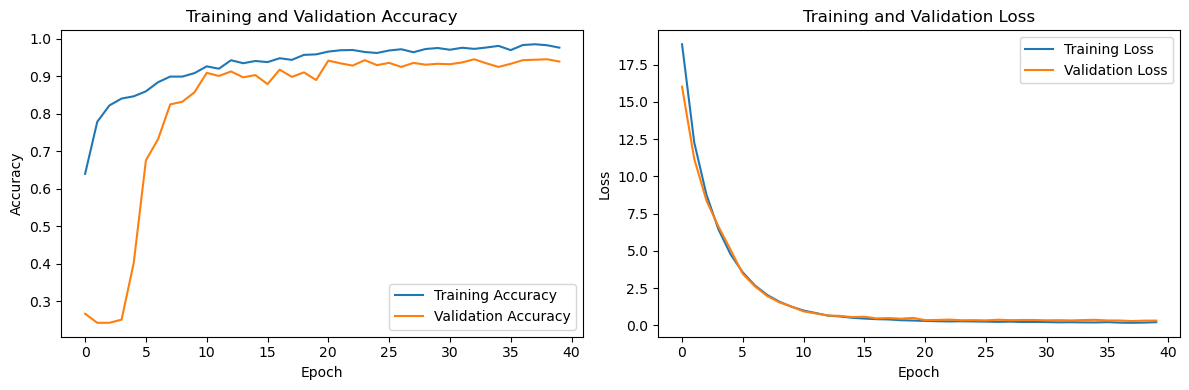

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
y_pred_eff = np.argmax(model_Efficientnet.predict(test_set['images']), 1)

12/12 [==============================] - 5s 120ms/step


In [41]:
print(classification_report(y_true, y_pred_eff, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.98      0.91      0.94       101
diabetic_retinopathy       0.99      0.99      0.99        89
            glaucoma       0.94      0.78      0.85        82
              normal       0.80      0.96      0.87       105

            accuracy                           0.92       377
           macro avg       0.93      0.91      0.92       377
        weighted avg       0.92      0.92      0.92       377



<Figure size 800x800 with 0 Axes>

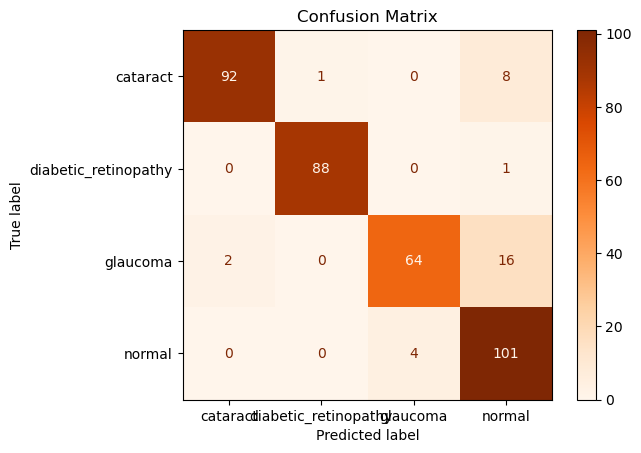

In [42]:
conf_matrix = confusion_matrix(y_true, y_pred_eff)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Oranges)
plt.title('Confusion Matrix')
plt.show()